In [ ]:
!pip install matplotlib
!pip install xarray netCDF4
!pip install numpy

In [4]:
import xarray as xr

# Ouvrir le fichier NetCDF
ds = xr.open_dataset("cmems_mod_glo_phy_my_0.083deg_P1D-m_1744892863122.nc")

# Afficher la structure du fichier
ds

<xarray.Dataset> Size: 106MB
Dimensions:    (time: 1, latitude: 2041, longitude: 4320, depth: 1)
Coordinates:
  * time       (time) datetime64[ns] 8B 2021-06-30
  * latitude   (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9
  * depth      (depth) float32 4B 0.494
Data variables:
    bottomT    (time, latitude, longitude) float32 35MB ...
    so         (time, depth, latitude, longitude) float32 35MB ...
    zos        (time, latitude, longitude) float32 35MB ...
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       MERCATOR OCEAN
    source:            MERCATOR GLORYS12V1
    history:           2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    references:        http://www.mercator-ocean.fr
    comment:           CMEMS product
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_MULTIYEAR_PHY_001_030
    subset:datasetId:  cmems_mod_glo_phy_my_0.083deg_P1D-m_202311
    subset:date:       2025-04-17T12:27:43.122Z

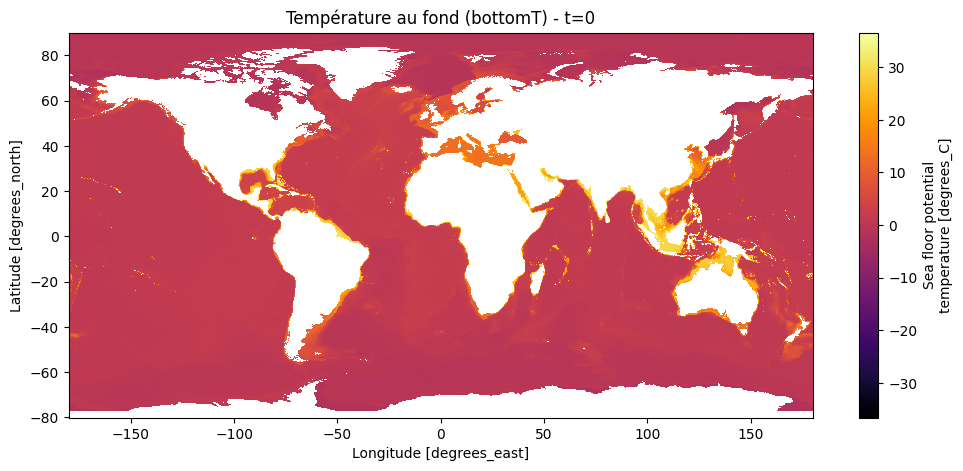

In [5]:
import matplotlib.pyplot as plt

# Extraire la variable à t=0
bottomT = ds["bottomT"].isel(time=0)

# Visualisation
plt.figure(figsize=(12, 5))
bottomT.plot(cmap="inferno")
plt.title("Température au fond (bottomT) - t=0")
plt.show()


In [6]:
#Conversion des données en un tableau numpy.
import xarray as xr
import numpy as np

# Extraire une variable (ex: température au fond)
data = ds["bottomT"].isel(time=0)  # (lat, lon)

# Normalisation (standard score)
data_np = data.values
mean = data_np.mean()
std = data_np.std()
data_norm = (data_np - mean) / std

# Optionnel : découpage en patchs si nécessaire


In [8]:
print(bottomT.shape)

(2041, 4320)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Fonction pour prétraiter les données xarray
def preprocess_ocean_data(ds, variable_name, patch_size=256):
    """
    Prétraite les données océaniques pour les adapter au VAE
    
    Args:
        ds: xarray.Dataset
        variable_name: nom de la variable à traiter ('bottomT', 'so', ou 'zos')
        patch_size: taille des patchs pour l'entraînement
    
    Returns:
        liste de tenseurs PyTorch pour l'entraînement
    """
    # Sélectionner la variable spécifiée
    if variable_name not in ds.data_vars:
        raise ValueError(f"Variable {variable_name} non trouvée dans le dataset")
    
    data_var = ds[variable_name]
    
    # Gérer les dimensions selon la variable
    if variable_name == 'so':  # so a une dimension depth
        # Prendre la première profondeur si c'est 'so'
        data = data_var.isel(time=0, depth=0).values
    else:  # bottomT et zos n'ont pas de dimension depth
        data = data_var.isel(time=0).values
    
    # Normaliser les données (important pour le VAE)
    # Gérer les valeurs manquantes (NaN)
    mask = ~np.isnan(data)
    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    
    # Remplacer les NaN par la moyenne
    data = np.where(mask, data, mean_val)
    
    # Normaliser entre -1 et 1
    data_normalized = (data - mean_val) / (std_val * 3)  # *3 pour s'assurer que la plupart des valeurs sont entre -1 et 1
    data_normalized = np.clip(data_normalized, -1, 1)
    
    # Diviser en patchs pour l'entraînement
    # Pour un dataset de 2041x4320, nous pouvons extraire des patchs de taille patch_size x patch_size
    patches = []
    
    for i in range(0, data.shape[0] - patch_size + 1, patch_size // 2):  # Chevauchement de 50%
        for j in range(0, data.shape[1] - patch_size + 1, patch_size // 2):
            patch = data_normalized[i:i+patch_size, j:j+patch_size]
            # Vérifier qu'il n'y a pas trop de valeurs manquantes dans le patch
            if np.mean(mask[i:i+patch_size, j:j+patch_size]) > 0.8:  # Au moins 80% de données valides
                patches.append(patch)
    
    # Convertir en tenseurs PyTorch (ajouter dimension de canal)
    tensor_patches = [torch.FloatTensor(patch).unsqueeze(0) for patch in patches]
    
    print(f"Extraction de {len(tensor_patches)} patchs de taille {patch_size}x{patch_size}")
    
    return tensor_patches, mean_val, std_val


In [ ]:
# Définition de l'architecture du VAE Convolutionnel adaptée aux données océaniques
class OceanConvVAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=128, patch_size=256):
        super(OceanConvVAE, self).__init__()
        
        # Adapter l'architecture au patch_size
        self.patch_size = patch_size
        
        # Encodeur - plus profond pour gérer les grandes dimensions
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        # Calculer la taille de sortie de l'encodeur
        # Pour un patch_size de 256, après 5 couches avec stride=2, 
        # la taille sera de 256 / 2^5 = 8
        self.encoded_size = patch_size // 32
        self.fc_size = 512 * self.encoded_size * self.encoded_size
        
        # Projections vers l'espace latent
        self.fc_mu = nn.Linear(self.fc_size, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_size, latent_dim)
        
        # De l'espace latent vers les caractéristiques pour le décodeur
        self.decoder_input = nn.Linear(latent_dim, self.fc_size)
        
        # Décodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Pour des données normalisées entre -1 et 1
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        x = self.decoder_input(z)
        # Reformater pour le décodeur
        x = x.view(x.size(0), 512, self.encoded_size, self.encoded_size)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [ ]:
# Fonction de perte pour VAE
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Perte de reconstruction (MSE pour des données continues)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # Terme de régularisation KL
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Perte totale (beta-VAE permet de contrôler l'importance du terme KL)
    return recon_loss + beta * kl_loss

In [ ]:
# Fonction d'entraînement
def train_vae(model, tensor_patches, epochs=50, batch_size=16, lr=1e-4, beta=0.5, device='cuda'):
    # Créer un dataset et dataloader
    dataset = TensorDataset(torch.stack(tensor_patches))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, (data,) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(data_loader)}, '
                      f'Loss: {loss.item() / len(data):.4f}')
        
        avg_loss = train_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}, Loss moyenne: {avg_loss:.4f}')
    
    return model


In [ ]:
# Fonction pour reconstruire une carte complète à partir du modèle entraîné
def reconstruct_full_map(model, ds, variable_name, patch_size=256, overlap=128, 
                         mean_val=0, std_val=1, device='cuda'):
    """
    Reconstruit une carte complète en appliquant le VAE sur des patchs avec chevauchement
    """
    model.eval()
    
    # Obtenir les dimensions de la carte complète
    if variable_name == 'so':
        full_map = ds[variable_name].isel(time=0, depth=0).values
    else:
        full_map = ds[variable_name].isel(time=0).values
    
    # Créer une carte reconstruite vide et un compteur pour les chevauchements
    recon_map = np.zeros_like(full_map)
    overlap_count = np.zeros_like(full_map)
    
    with torch.no_grad():
        for i in range(0, full_map.shape[0] - patch_size + 1, overlap):
            for j in range(0, full_map.shape[1] - patch_size + 1, overlap):
                # Extraire et normaliser le patch
                patch = full_map[i:i+patch_size, j:j+patch_size]
                mask = ~np.isnan(patch)
                
                # Seulement traiter les patchs avec suffisamment de données valides
                if np.mean(mask) > 0.8:
                    # Remplacer les NaN par la moyenne
                    patch = np.where(mask, patch, mean_val)
                    
                    # Normaliser
                    patch_normalized = (patch - mean_val) / (std_val * 3)
                    patch_normalized = np.clip(patch_normalized, -1, 1)
                    
                    # Convertir en tensor et ajouter dimension de batch et canal
                    tensor_patch = torch.FloatTensor(patch_normalized).unsqueeze(0).unsqueeze(0)
                    tensor_patch = tensor_patch.to(device)
                    
                    # Encoder-décoder avec le VAE
                    recon_patch, _, _ = model(tensor_patch)
                    
                    # Convertir en numpy et dénormaliser
                    recon_patch = recon_patch.squeeze().cpu().numpy()
                    recon_patch = recon_patch * (std_val * 3) + mean_val
                    
                    # Ajouter à la carte reconstruite
                    recon_map[i:i+patch_size, j:j+patch_size] += recon_patch
                    overlap_count[i:i+patch_size, j:j+patch_size] += 1
    
    # Moyenner les zones de chevauchement
    overlap_count[overlap_count == 0] = 1  # Éviter la division par zéro
    recon_map = recon_map / overlap_count
    
    # Conserver la structure des NaN de la carte originale
    mask_original = np.isnan(full_map)
    recon_map[mask_original] = np.nan
    
    return recon_map

In [ ]:
# Fonction pour extraire les caractéristiques latentes d'une carte complète
def extract_latent_features(model, ds, variable_name, patch_size=256, stride=128, 
                           mean_val=0, std_val=1, device='cuda'):
    """
    Extrait les caractéristiques latentes des patchs de la carte
    """
    model.eval()
    
    # Préparer les données
    if variable_name == 'so':
        full_map = ds[variable_name].isel(time=0, depth=0).values
    else:
        full_map = ds[variable_name].isel(time=0).values
    
    latent_vectors = []
    patch_positions = []  # Pour garder la trace des positions des patchs
    
    with torch.no_grad():
        for i in range(0, full_map.shape[0] - patch_size + 1, stride):
            for j in range(0, full_map.shape[1] - patch_size + 1, stride):
                # Extraire et normaliser le patch
                patch = full_map[i:i+patch_size, j:j+patch_size]
                mask = ~np.isnan(patch)
                
                # Seulement traiter les patchs avec suffisamment de données valides
                if np.mean(mask) > 0.8:
                    # Remplacer les NaN par la moyenne
                    patch = np.where(mask, patch, mean_val)
                    
                    # Normaliser
                    patch_normalized = (patch - mean_val) / (std_val * 3)
                    patch_normalized = np.clip(patch_normalized, -1, 1)
                    
                    # Convertir en tensor et ajouter dimension de batch et canal
                    tensor_patch = torch.FloatTensor(patch_normalized).unsqueeze(0).unsqueeze(0)
                    tensor_patch = tensor_patch.to(device)
                    
                    # Extraire les caractéristiques latentes
                    mu, _ = model.encode(tensor_patch)
                    
                    # Stocker le vecteur latent et la position
                    latent_vectors.append(mu.cpu().numpy())
                    patch_positions.append((i, j))
    
    return np.vstack(latent_vectors), patch_positions


In [ ]:
# Utilisation
def main():
    # Paramètres
    variable_name = 'zos'  # 'bottomT', 'so', ou 'zos'
    patch_size = 256  # Taille des patchs pour l'entraînement
    latent_dim = 128  # Dimension de l'espace latent
    epochs = 50
    batch_size = 16
    lr = 1e-4
    beta = 0.5  # Facteur de pondération du terme KL dans la fonction de perte
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Prétraiter les données
    tensor_patches, mean_val, std_val = preprocess_ocean_data(ds, variable_name, patch_size)
    
    # Instancier le modèle
    model = OceanConvVAE(input_channels=1, latent_dim=latent_dim, patch_size=patch_size)
    
    # Entraîner le modèle
    model = train_vae(model, tensor_patches, epochs, batch_size, lr, beta, device)
    
    # Sauvegarder le modèle
    torch.save({
    'model_state_dict': model.state_dict(),
    'mean_val': mean_val,
    'std_val': std_val,
    'patch_size': patch_size,
    'latent_dim': latent_dim
    }, f'ocean_vae_{variable_name}.pth')
    
    # Reconstruction et visualisation
    recon_map = reconstruct_full_map(model, ds, variable_name, patch_size, patch_size//2, mean_val, std_val, device)
    
    # Extraction des caractéristiques latentes
    latent_features, patch_positions = extract_latent_features(model, ds, variable_name, patch_size, patch_size//2, mean_val, std_val, device)
    
    return model